# Relatório e código do Trabalho Prático de Análise e Transformação de Dados

## 1. Importar Sinais Necessários

Para importar os dados necessários, começamos por criar uma função que lê os ficheiros presentes numa pasta com os DataSets a analisar, e verfica se o formato do nome dos mesmos está de acordo com o necessário

Começaremos a nossa análise por ler o ficheiro, fazendo as verificações básicas á possibilidade de execução

In [48]:
dados = lerDados();
labels = lerLabel([dados{:,3}]);
activity_labels = lerActivityLabel();
if(~isa(dados,'cell'))
    return
end


activity_labels =

  12x1 cell array

    {'WALKING'           }
    {'WALKING_UPSTAIRS'  }
    {'WALKING_DOWNSTAIRS'}
    {'SITTING'           }
    {'STANDING'          }
    {'LAYING'            }
    {'STAND_TO_SIT'      }
    {'SIT_TO_STAND'      }
    {'SIT_TO_LIE'        }
    {'LIE_TO_SIT'        }
    {'STAND_TO_LIE'      }
    {'LIE_TO_STAND'      }




In [49]:
%%file lerDados.m
function data = lerDados()
PATH = "Data_PL2";
ficheiro_path = dir(PATH);
numero_ficheiros = length(ficheiro_path)-2;
data = cell(numero_ficheiros,3);
string_patern = digitsPattern;

for i = 1:numero_ficheiros
    dados_exp = str2double(extract(ficheiro_path(i+2).name, string_patern));
    if(length(dados_exp) ~= 2)
        warning("Erro a ler conteudo da pasta, verifique a sua pasta e o parsing do ficheiro " + ficheiro_path(i+2).name);
        data = [];
        break
    end
    data{i,1} = (load(PATH + '\' + ficheiro_path(i+2).name));
    data{i,2} = dados_exp(2); %Guardar utilizador
    data{i,3} = dados_exp(1); %Guardar numero experiencia
end

Created file 'C:\Users\User\Desktop\2ºAno\ATD\PROJETO\lerDados.m'.


In [50]:
%%file lerLabel.m
function label = lerLabel(experiencias)
PATH = "Help\labels.txt";
temp = load(PATH);

temp = temp(ismember(temp(:, 1),experiencias), :);

label = struct('exp_num', num2cell(temp(:, 1)), 'user', num2cell(temp(:, 2)), ...
'activity', num2cell(temp(:, 3)), 'start', num2cell(temp(:, 4)), ...
'end',num2cell(temp(:, 5)));

Created file 'C:\Users\User\Desktop\2ºAno\ATD\PROJETO\lerLabel.m'.


In [51]:
%%file lerActivityLabel.m

function label = lerActivityLabel()
PATH = "Help\activity_labels.txt";

temp = table2cell(readtable(PATH));
label = temp(:, 2);

Created file 'C:\Users\User\Desktop\2ºAno\ATD\PROJETO\lerActivityLabel.m'.


## 2. Representar graficamente os sinais importados, identificando a atividade a que cada fragmento corresponde.

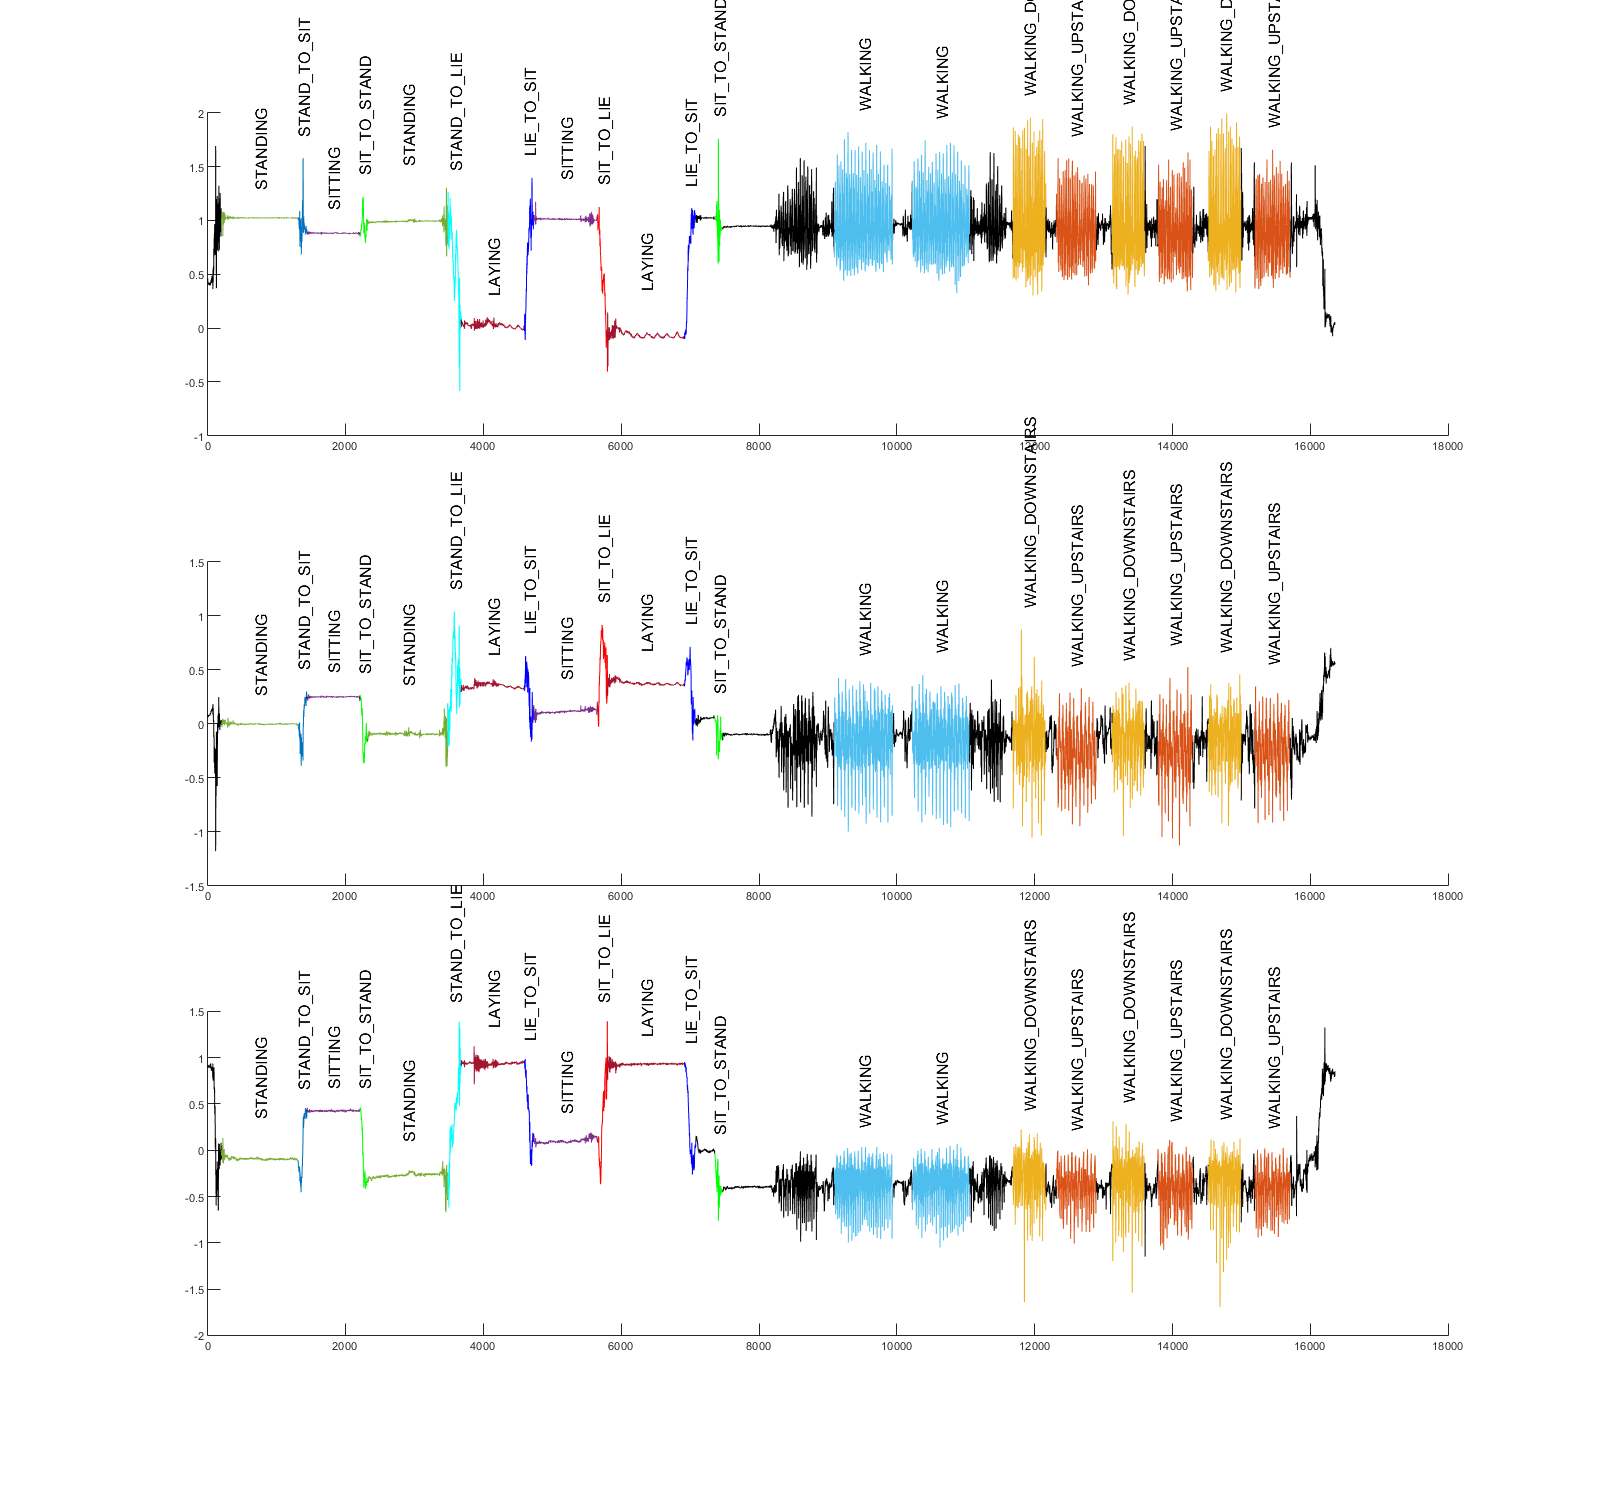

In [84]:
%plot -b inline -w 1600 -h 1500
[indx,tf] = listdlg('ListString', strsplit(num2str([dados{:,3}])), 'SelectionMode','single', 'Name','Escolha uma experiencia para visualizar');
user_plot(dados, labels, activity_labels, indx)

In [83]:
%%file user_plot.m

function user_plot(dados, label, activity_label, index)

colors = ['#4DBEEE';'#D95319';'#EDB120';'#7E2F8E';'#77AC30';'#A2142F';'#0072BD';'#00FF00';'#FF0000';'#0000FF';'#00FFFF';'#FF00FF'];

exp_labels = find([label.exp_num] == dados{index, 3});
figure(1);
for j = 1:3
    subplot(3,1,j);
    hold on
    start = 1;
    for i = exp_labels
        %Obter pontos fora das atividades
        if label(i).start > start
            data_range = start:label(i).start;
            data_output = dados{index,1}(data_range,j);
            plot(data_range,data_output, 'k');
        end
        %obter atividade
        actv_num = label(i).activity;
        data_range = label(i).start:label(i).end;
        data_output = dados{index,1}(data_range,j);
        plot(data_range,data_output, 'color', colors(actv_num,:));
        start = label(i).end;
        text_pos_y = max(data_output) + 0.2;
        
        txt = activity_label(actv_num);
        t = text(double((label(i).start+label(i).end)/2), text_pos_y,txt);
        t.Interpreter = 'none';
        t.FontSize = 12;
        t.Rotation = 90;
    end
    last = length(dados{index,1}(:,j));
    data_range = (start:last);
    data_output = dados{index,1}(data_range,j);
    plot(data_range, data_output, 'k');
    hold off
end

Created file 'C:\Users\User\Desktop\2ºAno\ATD\PROJETO\user_plot.m'.
